<a href="https://colab.research.google.com/github/DeKUT-DSAIL/dsa-2024-nlp/blob/main/main-lab/basic_nlp_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BASIC NLP Lab
In this section, we shall create more emphasis on what has already been covered in the pre-lab.

## Objectives
* Understand sentence segmentation.
* Understand various ways of getting word embeddings.
* Understand Part of Speech (POS) tagging.
* Understand Named Entity Recognition (NER).

Run this notebook at your own pace. Most of the code is already here, together with explanations. However, feel free to go back to the pre-lab to cross-reference related sections.
Furthermore, there are a few places marked with `# Your code here` that require you to write code for the cells to run. Typically an archetype of this code can be found in the corresponding pre-lab notebook.

In [1]:
# Install packages
! pip install contractions
! pip install nltk
! pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 12.8 MB/s eta 0:00:00


In [2]:
# Load dependencies
import numpy as np
import re
import requests
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
from nltk.corpus import gutenberg, stopwords, wordnet
from nltk import FreqDist, word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.util import trigrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter
import spacy
from spacy.tokenizer import Tokenizer
import math
import contractions
from itertools import islice

In [3]:
# Init spacy
nlp = spacy.load('en_core_web_sm')
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


### Text cleaning

**Optional**. This is a standalone introductory section. You can skip it if you're confident in your understanding of text cleaning.

Text cleaning is a fundamental pre-step before running machine learning models on text. This is simply because as humans we communicate differently compared to what an algorithm deems essential for working with text. For example, words like `a, the` etc might not be as important for the algorithm. Let's explore this below.

Let us first work with the reuters dataset which contains short articles from Reuters.

In [4]:
nltk.download('reuters')
from nltk.corpus import reuters
categories = ['nickel', 'gold', 'silver', 'tea', 'barley', 'fuel', 'crude', 'gas', 'heat']
fields_for_categories = []
docs_per_category = 10
for c in categories:
  fields_for_categories.append(reuters.fileids(c)[0:docs_per_category])


[nltk_data] Downloading package reuters to /root/nltk_data...


In [5]:
reuters_sample = ' '.join(reuters.words(fields_for_categories[1]))
reuters_sample[0:50]

'WESTERN MINING TO OPEN NEW GOLD MINE IN AUSTRALIA '

In [6]:
def tokenize_text(text):
    pattern = r"[a-zA-Z]+(?:'[a-z]+)?"  # Regex pattern to match words, including those with apostrophes
    text_tokens = nltk.regexp_tokenize(text, pattern)  # Tokenize using the regex pattern
    lemmatizer = WordNetLemmatizer()
    text_tokens = [lemmatizer.lemmatize(word.lower().strip()) for word in text_tokens]  # Convert tokens to lowercase, lemmatize, remove extra whitespace
    return text_tokens

In [7]:
r_sample_tokens = tokenize_text(reuters_sample) # tokenize the text
r_sample_freqdist =FreqDist(r_sample_tokens) # Get frequency distributions
r_sample_freqdist.most_common(15)

[('the', 80),
 ('to', 40),
 ('of', 40),
 ('a', 37),
 ('and', 31),
 ('gold', 29),
 ('said', 27),
 ('in', 22),
 ('at', 20),
 ('s', 16),
 ('it', 15),
 ('with', 13),
 ('warrant', 13),
 ('is', 11),
 ('dlrs', 10)]

To automatically define stop-words, we can assume that these are words that occur very frequently.
If we have a small corpus that is limited to a specific domain, like all articles about "gold" in the reuters dataset used above, then this is not a great strategy.
We see that the word "gold" is very frequent (since it's the topic of this dataset selection), however it's not a stopword.

Clearly we don't want to remove words like "gold" since this is the category of the article.

Let's then load a set of stopwords that is computed on "all" of english language.

In [8]:
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

example_sent = """This is a sample sentence,
                  showing off the stop words filtration."""


def filter_stop_words(sent, return_as_list=False):
  sent_tokenized = word_tokenize(sent)
  ret = [w for w in sent_tokenized if not w.lower() in stop_words]
  if return_as_list:
    return ret
  else:
    return ' '.join(ret)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
print(f'Original text: {reuters_sample[0:50]}')
print(f'Filtered text: {filter_stop_words(reuters_sample[0:50])}')

Original text: WESTERN MINING TO OPEN NEW GOLD MINE IN AUSTRALIA 
Filtered text: WESTERN MINING OPEN NEW GOLD MINE AUSTRALIA


Let's now define a more generic clean text function.
What else should a text be cleaned for? For example, 'constitutes' can be changed to 'constitute', since the exact form of a verb is not as useful for semantic text processing tasks.

Consider the following text:

In [10]:
example_text = """Lorem Ipsum is simply dummy text of the printing and typesetting industry. \
Lorem Ipsum constitutes the industry's standard dummy text ever since the 1500s, when an unknown \
printer took a galley of type and scrambled it to make a type specimen book. It has survived not \
only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. \
It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, \
and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum."""

In [19]:
def clean_text1(text):
  text = contractions.fix(text) # Fix contractions
  text = text.lower() # lowercase the text
  text = text.replace('\n', ' ') # replace new line characters with whitespace
  text = re.sub(r"[^\w\s']", ' ', text) # Remove non-word characters, except apostroophes - to handle possessives correctly e.g "John's"
  text = text.strip() # Remove extra whitespace

  ## -- Tokenize, lemmatize, remove stopwords -- ##
  doc = nlp(text)
  tokens = [token.lemma_.strip() for token in doc if not token.is_stop and not token.is_punct] # Lemmatize and exclude stopwords
  tokens = [token for token in tokens if token != ''] # Exclude empty strings
  return tokens

In [20]:
print(clean_text1(example_text))

['lorem', 'ipsum', 'simply', 'dummy', 'text', 'printing', 'typeset', 'industry', 'lorem', 'ipsum', 'constitute', 'industry', 'standard', 'dummy', 'text', '1500s', 'unknown', 'printer', 'take', 'galley', 'type', 'scramble', 'type', 'speciman', 'book', 'survive', 'century', 'leap', 'electronic', 'typesetting', 'remain', 'essentially', 'unchanged', 'popularise', '1960', 'release', 'letraset', 'sheet', 'contain', 'lorem', 'ipsum', 'passage', 'recently', 'desktop', 'publishing', 'software', 'like', 'aldus', 'pagemaker', 'include', 'version', 'lorem', 'ipsum']


### N-grams

**Optional** This is a standalone section. You can skip it if you're confident in your understanding of n-grams.

N-grams are continuous sequences of n words from a given text. Types of n-grams include:
* Unigrams - 1 word e.g ('God'). This can also be viewed as frequency distribution.
* Bigrams - 2 words e.g ('Lord', 'God')
* Trigrams - 3 words e.g ('Lord', 'God', 'said')

Consider the below sentence and try to identify the top 3 n-grams by frequency, for n = 2,3.
Try to do this manually, i.e. in your head or using pen and paper. You just have to write the pairs of occurences for words (or triplets for 3-grams etc) and count their frequency.

In [ ]:
example_sentence = '''A cat jumped over the bed.
The cat jumped over the bed quickly.
The cat jumped over the fence.
The dog chased the cat.
The dog chased a squirrel.
The man chased the cat.'''

Now implement code to compute ngrams programmatically - you can look at the pre-lab notebook.

In [ ]:
# ngrams code

# Your code here

# def ngrams(tokens, n):
  # TODO

# def ngram_freq(text, n):
  # TODO

In [ ]:
ngram_freq(filter_stop_words(example_sentence),2)

[(('cat', 'jump'), 3),
 (('jump', 'bed'), 2),
 (('dog', 'chase'), 2),
 (('chase', 'cat'), 2),
 (('bed', 'cat'), 1),
 (('bed', 'quickly'), 1),
 (('quickly', 'cat'), 1),
 (('jump', 'fence'), 1),
 (('fence', 'dog'), 1),
 (('cat', 'dog'), 1),
 (('chase', 'squirrel'), 1),
 (('squirrel', 'man'), 1),
 (('man', 'chase'), 1)]

In [ ]:
ngram_freq(filter_stop_words(example_sentence),3)

[(('cat', 'jump', 'bed'), 2),
 (('jump', 'bed', 'cat'), 1),
 (('bed', 'cat', 'jump'), 1),
 (('jump', 'bed', 'quickly'), 1),
 (('bed', 'quickly', 'cat'), 1),
 (('quickly', 'cat', 'jump'), 1),
 (('cat', 'jump', 'fence'), 1),
 (('jump', 'fence', 'dog'), 1),
 (('fence', 'dog', 'chase'), 1),
 (('dog', 'chase', 'cat'), 1),
 (('chase', 'cat', 'dog'), 1),
 (('cat', 'dog', 'chase'), 1),
 (('dog', 'chase', 'squirrel'), 1),
 (('chase', 'squirrel', 'man'), 1),
 (('squirrel', 'man', 'chase'), 1),
 (('man', 'chase', 'cat'), 1)]

In [ ]:
ngram_freq(filter_stop_words(reuters_sample), 2)[0:10]

[(('Cape', 'Spencer'), 6),
 (('000', 'ton'), 6),
 (('`', '`'), 5),
 (('GOLD', 'WARRANTS'), 4),
 (('April', '30'), 4),
 (('100', 'gramme'), 4),
 (('gold', 'price'), 4),
 (('ton', 'gold'), 4),
 (('gold', 'bear'), 4),
 (('bear', 'deposit'), 4)]

The above hopefully makes some sense and it's what one should expect (this is a limited domain with a simple stop word filtration, so the results won't be perfect!).

## Sentence Segmentation
Sentence segmentation invlolves the identification of of sentence boundaries between words, and dividing the text into individual sentences based on the established boundaries.

This can be done by using the following methods:
* A vivid indication of the sentence end such as '?' or '!'
* Using an unclear indication such as the period (.) - This may have several other uses such as abbreviations. For example, when abbrevition Mr.

One way to think about sentence segmentation is that it is tokenization at the sentence level, where the tokens are sentences as opposed to words like we saw earlier during the pre-lab. The machine can learn to know the difference between a sentence end and an abbreviation.

Sentence segmentation can be important in certain tasks such as machine translation and text summarization.

The two popular approaches to sentence segmentation are rule-based and machine learning-based sentence segmentation. In this lab, we shall look at rule-based sentence segmentation using the default rules. Using spaCy, one could add a custom rule to spaCy's nlp pipeline.

To demonstrate the above, we return to the Gutenberg corpus, familiar from the pre-lab notebooks.

In [ ]:
# Run without making changes
def request_gutenberg(url):

  # Make a request to the url
  response = requests.get(url)

  # check if the request was successful
  if response.status_code == 200:
    book = response.text

  else:
    print(f"Failed to retrieve the text version. Status code: {response.status_code}")

  # remove unwanted new line and tab characters from the text, replacing with whitespace
  unwanted_chars = ["\n", "\r", "\d", "\t"]
  for char in unwanted_chars:
      book = book.replace(char, " ")

  return book

# URLs of the books to be used in this lab
g_gatsby_url = "https://www.gutenberg.org/cache/epub/64317/pg64317.txt"
huckleberry_finn_url = "https://www.gutenberg.org/cache/epub/76/pg76.txt"
sherlock_holmes_url = "https://www.gutenberg.org/files/1661/1661-0.txt"

# Make requests for each book
g_gatsby = request_gutenberg(g_gatsby_url)[1494:277912] # Remove introduction and footnotes
h_berry = request_gutenberg(huckleberry_finn_url)[9528:-18862]
s_holmes = request_gutenberg(sherlock_holmes_url)[1508:-18859]

books = {
    "The Great Gatsby": g_gatsby,
    "Adventures of Huckleberry Finn": h_berry,
    "The Adventures of Sherlock Holmes": s_holmes
    }

# Preview
for key, val in books.items():
  print(f"{key}:")
  print(val[:500])
  print("="*100)

The Great Gatsby:
I    In my younger and more vulnerable years my father gave me some advice  that I’ve been turning over in my mind ever since.    “Whenever you feel like criticizing anyone,” he told me, “just  remember that all the people in this world haven’t had the advantages  that you’ve had.”    He didn’t say any more, but we’ve always been unusually communicative  in a reserved way, and I understood that he meant a great deal more  than that. In consequence, I’m inclined to reserve all judgements, a  habi
Adventures of Huckleberry Finn:
CHAPTER I.      You don’t know about me without you have read a book by the name of The  Adventures of Tom Sawyer; but that ain’t no matter. That book was made  by Mr. Mark Twain, and he told the truth, mainly. There was things  which he stretched, but mainly he told the truth. That is nothing. I  never seen anybody but lied one time or another, without it was Aunt  Polly, or the widow, or maybe Mary. Aunt Polly—Tom’s Aunt Polly, she  is—and Mar

In [ ]:
def fix_encoding(text):
    # Encode the incorrectly decoded text back to bytes
    bytes_text = text.encode('latin1')
    # Decode the bytes using the correct encoding (UTF-8)
    corrected_text = bytes_text.decode('utf-8')
    return corrected_text

# Fix encoding of sherlock holmes
s_holmes = fix_encoding(s_holmes)
s_holmes[:500]

'A SCANDAL IN BOHEMIA      I.    To Sherlock Holmes she is always _the_ woman. I have seldom heard him  mention her under any other name. In his eyes she eclipses and  predominates the whole of her sex. It was not that he felt any emotion  akin to love for Irene Adler. All emotions, and that one particularly,  were abhorrent to his cold, precise but admirably balanced mind. He  was, I take it, the most perfect reasoning and observing machine that  the world has seen, but as a lover he would have '

In [ ]:
# Get the end of the first chapter for both the Adventures of Sherlock Holmes and Adventures of Huckleberry Finn
s_holmes_chap_1_end = s_holmes.index('II')
h_berry_chap_1_end = h_berry.index('CHAPTER II')

### Rule-based Sentence segmentation
In the code cells below, we shall segment sentences using nltk and spacy, spaCy's pre-trained models and etymological rules accurately identify sentence boundaries by using cues such as punctuation, capitalization, and other language-specific indicators.. How many sentences do we arrive at using this method?

In [ ]:
# using the first chapter of 'Adventures of Huckleberry Finn'
h_berry_chap_1 = h_berry[16:h_berry_chap_1_end]

# Using NLTK
h_berry_sents_nltk = nltk.sent_tokenize(h_berry_chap_1)
print("Using NLTK:")
print(h_berry_sents_nltk[:15])
print(f"Number of sentences: {len(h_berry_sents_nltk)}")

# Using spacy
doc = nlp(h_berry_chap_1)

h_berry_sents_spacy = [sent.text for sent in doc.sents]
print("\nUsing Spacy:")
print(h_berry_sents_spacy[:15])
print(f"Number of sentences: {len(h_berry_sents_spacy)}")

Using NLTK:
['You don’t know about me without you have read a book by the name of The  Adventures of Tom Sawyer; but that ain’t no matter.', 'That book was made  by Mr. Mark Twain, and he told the truth, mainly.', 'There was things  which he stretched, but mainly he told the truth.', 'That is nothing.', 'I  never seen anybody but lied one time or another, without it was Aunt  Polly, or the widow, or maybe Mary.', 'Aunt Polly—Tom’s Aunt Polly, she  is—and Mary, and the Widow Douglas is all told about in that book,  which is mostly a true book, with some stretchers, as I said before.', 'Now the way that the book winds up is this: Tom and me found the money  that the robbers hid in the cave, and it made us rich.', 'We got six  thousand dollars apiece—all gold.', 'It was an awful sight of money when  it was piled up.', 'Well, Judge Thatcher he took it and put it out at  interest, and it fetched us a dollar a day apiece all the year  round—more than a body could tell what to do with.', 'The

In [ ]:
# Get the first chapter of The Adventures of Sherlock Holmes and perform the sentence segmentation
s_holmes_chap_1 = s_holmes[32:s_holmes_chap_1_end]

# Your code here


## Word Embeddings
The discussion on word embeddings began with an exploration of Bag of Words (BoW) techniques like CountVectorizer and Term Frequency-Inverse Document Frequency (TF-IDF) in the pre-lab. Now, we delve into other methodologies for creating word embeddings.

### Word2Vec
Word2Vec, devised by Google researchers, introduces a neural approach to generating word embeddings. This model processes extensive text corpora and produces high-quality word vectors. It boasts the capability to analyze word contexts, thereby capturing semantic relationships as it maps words to high-dimensional vectors.

#### Continuous Bag of Words (CBOW)
CBOW, an unsupervised learning method, aims to predict a target word by considering its context—surrounding words within a specified window. It predicts the central word within the window and represents embeddings in a continuous vector space.

In contrast to BoW, which disregards word context and thus fails to capture complete text meaning, CBOW's contextual awareness enhances its ability to capture textual semantics.

#### Skip-Gram
The Skip-Gram model seeks distributed word representations within a continuous vector space. Its objective is to predict context words (those adjacent to a target word) given the target word itself. This differs from CBOW, which predicts the target word from its surrounding context. Research suggests that Skip-Gram yields embeddings with richer semantic content compared to other methods.

The choice between CBOW and Skip-Gram models hinges on data characteristics and task objectives. CBOW is favored with limited training data, prioritizing syntactic nuances. Conversely, Skip-Gram excels in capturing semantic associations and effectively representing infrequent words.

The decision to train Word2Vec models using sentences or tokens depends on desired granularity in word embeddings and text data structure. Using entire sentences focuses on contextual information within sentences, beneficial for tasks like sentiment analysis. Employing individual tokens considers broader semantic relationships across the corpus, ideal for tasks like semantic similarity.

Given the goal of understanding corpora broadly, using word tokens is preferred. The text preprocessing steps from the pre-lab will be utilized for this purpose.


In [ ]:
# Load dependencies
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import warnings

# Disable warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

**Attention!!** For the following to run, you need to have run the `clean_text1` function in the "Text Cleaning" section from before.

In [ ]:
# Clean the text of the Great Gatsby
gatsby_tokens = clean_text1(g_gatsby)
gatsby_tokens = [token for token in gatsby_tokens if token != ''] # Exclude empty strings

# Get the set of items
n_gatsby_tokens = len(list(set(gatsby_tokens)))
print(f"Number of distinct tokens: {n_gatsby_tokens}")

Number of distinct tokens: 4505


In [ ]:
# Clean the text of The Adventures of Huckleberry Finn, getting the tokens and the number of distinct tokens

# Your code here

In [ ]:
import multiprocessing

# Count the number of cores in the cpu
cores = multiprocessing.cpu_count()

In [ ]:
# CBOW model of the great gatsby text
cbow_gatsby_model = Word2Vec(sentences=[gatsby_tokens],
                             vector_size=100,  # Dimensionality of the word vectors
                             window=5,         # Maximum distance between the current and predicted word within a sentence
                             sg=0,             # CBOW model (0 for CBOW, 1 for Skip-Gram)
                             min_count=10,      # Ignores all words with a total frequency lower than this
                             workers=cores-1)       # cpu cores

# Training
cbow_gatsby_model.train([gatsby_tokens], total_examples=1, epochs=100)

# Vector representation of gatsby
word = 'gatsby'
gatsby_vector_rep = cbow_gatsby_model.wv[word]
print(f"CBOW Vector representation of {word}: {gatsby_vector_rep}")

CBOW Vector representation of gatsby: [-8.86559725e-01 -1.81378528e-01  4.39616174e-01  4.64231253e-01
  2.05618832e-02 -5.57845533e-01 -5.56949377e-01  4.45696414e-01
  5.03326833e-01 -1.13711345e+00  9.85719636e-02  3.37011695e-01
  2.40804311e-02  6.06875420e-01  6.55139387e-02 -1.01007462e-01
 -3.10799092e-01  6.86958015e-01 -1.73614338e-01 -6.03697658e-01
  7.09214330e-01  6.79432452e-02  9.65071499e-01  2.13001981e-01
  8.58468711e-01 -2.65913308e-01 -8.63000825e-02  5.98906279e-02
 -8.99318159e-01  1.71200007e-01 -1.76569656e-01 -2.75519639e-01
  8.16894054e-01 -4.45926994e-01  2.40044102e-01  1.61812589e-01
  3.16141057e-04  6.72519729e-02 -8.06340426e-02 -1.27146160e-02
  6.94722533e-01  6.19589031e-01 -3.11790198e-01 -3.15368891e-01
  5.91712177e-01  1.18288195e+00 -7.41057158e-01  5.85344613e-01
  8.42276037e-01  1.87176481e-01 -3.61720979e-01  3.71268749e-01
 -4.38868970e-01 -2.42873579e-02  2.52481788e-01  9.66386646e-02
 -2.50279129e-01 -2.17346281e-01 -3.55394334e-01  9.

In [ ]:
# Skipgram model of the Great Gatsby text
skipgram_gatsby_model = Word2Vec(sentences=[gatsby_tokens],
                          vector_size=100,  # Dimensionality of the word vectors
                          window=5,         # Maximum distance between the current and predicted word within a sentence
                          sg=1,             # Skip-Gram model (1 for Skip-Gram, 0 for CBOW)
                          min_count=10,      # Ignores all words with a total frequency lower than this
                          workers=cores-1)       # cpu cores

# Training
skipgram_gatsby_model.train([gatsby_tokens], total_examples=1, epochs=100)

# Vector representation of gatsby
word = 'gatsby'
gatsby_vector_rep = skipgram_gatsby_model.wv[word]
print(f"Skipgram Vector representation of {word}: \n{gatsby_vector_rep}")

Skipgram Vector representation of gatsby: 
[-0.18024732 -0.09232956  0.14114104  0.12256143 -0.02509932 -0.306543
 -0.22930494  0.24378636 -0.02201081 -0.22165959 -0.12634744 -0.06986495
 -0.16867855  0.09658261  0.32023928 -0.05351266  0.19858286  0.02122142
  0.15911448 -0.2352864   0.12479225  0.00833586  0.28793105 -0.16111344
  0.01476592 -0.0874582  -0.16370517 -0.14192711 -0.50962186  0.02396614
  0.23980975 -0.03289191  0.04989801 -0.12883507 -0.20222813  0.33914214
  0.07537403 -0.03964567  0.04666974  0.02001024  0.08658332  0.06286446
 -0.0383154  -0.08729084  0.0425876   0.12443601 -0.03918268  0.14614365
  0.2214018  -0.05582196 -0.15995441  0.30738533 -0.04310428  0.01073627
 -0.14284793  0.19741325 -0.03511769 -0.12847136 -0.17367467  0.07212719
  0.12195329  0.02406472 -0.13553993 -0.14818038 -0.06976158  0.3482297
 -0.06981976  0.24920073  0.02648384  0.2728288  -0.14204346 -0.12543984
 -0.11373128 -0.12506995  0.22557789  0.21130554 -0.26010925 -0.10203975
 -0.0334318

In [ ]:
# Create the Skipgram model of The Adventures of Huckleberry Finn

# Vector representation of huck


#### Exploring the model (Optional)

In the code cells, we shall explore the model to perform some simple character analysis of the books The Great Gatsby and Advenures of Huckleberry Finn, that you can confirm later on after the lab as your homework.

In [ ]:
# Investigating the love triangle of the great gatsby
# Investigate the relationships between the key characters
gatsby_relationships = {
    ('gatsby', 'daisy'): skipgram_gatsby_model.wv.similarity('gatsby', 'daisy'),
    ('gatsby', 'tom'): skipgram_gatsby_model.wv.similarity('gatsby', 'tom'),
    ('daisy', 'tom'): skipgram_gatsby_model.wv.similarity('daisy', 'tom'),
}

print("Character relationships based on cosine similarity:")
for (char1, char2), similarity in gatsby_relationships.items():
    print(f"Similarity between {char1} and {char2}: {similarity:.4f}")

Character relationships based on cosine similarity:
Similarity between gatsby and daisy: 0.3974
Similarity between gatsby and tom: 0.3467
Similarity between daisy and tom: 0.5306


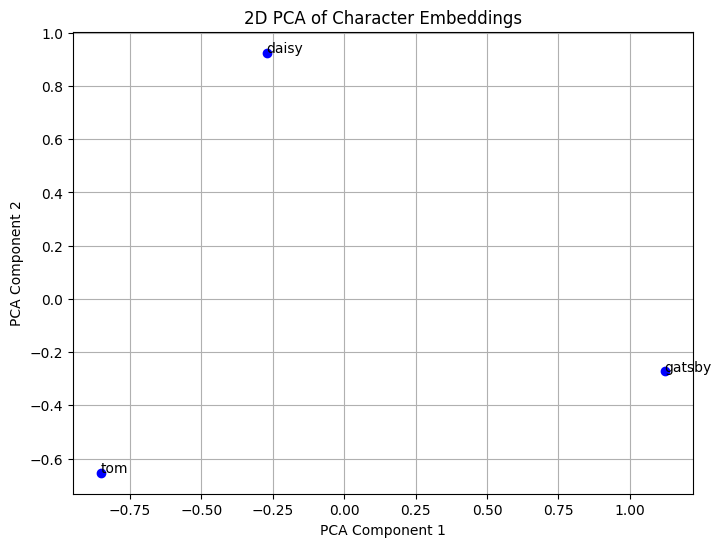

In [ ]:
# Visualize the word vectors (optional)
# You can use a dimensionality reduction technique like PCA or t-SNE to visualize the vectors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

gatsby_key_characters = ['gatsby', 'daisy', 'tom']

# Get the vectors for the key characters
vectors = [skipgram_gatsby_model.wv[char] for char in gatsby_key_characters if char in skipgram_gatsby_model.wv]

# Perform PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

# Plot the vectors
plt.figure(figsize=(8, 6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c='blue')
for i, char in enumerate(gatsby_key_characters):
    if char in skipgram_gatsby_model.wv:
        plt.annotate(char, (reduced_vectors[i, 0], reduced_vectors[i, 1]))
plt.title('2D PCA of Character Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

In [ ]:
# Get Similaries using The Adventures of Huckleberry Finn (Optional)


# Define key characters
huck_key_characters = ['huck', 'jim', 'pap', 'duke']


# Investigate the relationships between the characters

# Your code here

# Print the cosine similarities of the relationships in Adventures iof Huckleberry Finn

# Your code here

## Parts of Speech Tagging (POS)

In the code cells below, we shall perform simple POS.
In this section, we shall use sentences from 'Adventures of Huckleberry Finn' and 'The Adventures of Sherlock Holmes'.

In [ ]:
from spacy import displacy # import spaCy's visualizer

In [ ]:
# Get the first 5 sentences of Huckleberry Finn as the corpus
h_berry_corpus = h_berry_sents_spacy[:5]

# Join the sentences into a single text for SpaCy processing
text = ' '.join(h_berry_corpus)

# Process the text with SpaCy
h_berry_doc = nlp(text)

# Initialize an empty dictionary to store the POS tags
h_berry_pos_tags = {}

# Print POS tags for each token and store them in the dictionary
for token in h_berry_doc:
    h_berry_pos_tags[token.text] = (token.pos_,spacy.explain(token.pos_))

h_berry_pos_tags

{'You': ('PRON', 'pronoun'),
 'do': ('AUX', 'auxiliary'),
 'n’t': ('PART', 'particle'),
 'know': ('VERB', 'verb'),
 'about': ('ADP', 'adposition'),
 'me': ('PRON', 'pronoun'),
 'without': ('SCONJ', 'subordinating conjunction'),
 'you': ('PRON', 'pronoun'),
 'have': ('AUX', 'auxiliary'),
 'read': ('VERB', 'verb'),
 'a': ('DET', 'determiner'),
 'book': ('NOUN', 'noun'),
 'by': ('ADP', 'adposition'),
 'the': ('DET', 'determiner'),
 'name': ('NOUN', 'noun'),
 'of': ('ADP', 'adposition'),
 'The': ('DET', 'determiner'),
 ' ': ('SPACE', 'space'),
 'Adventures': ('PROPN', 'proper noun'),
 'Tom': ('PROPN', 'proper noun'),
 'Sawyer': ('PROPN', 'proper noun'),
 ';': ('PUNCT', 'punctuation'),
 'but': ('CCONJ', 'coordinating conjunction'),
 'that': ('PRON', 'pronoun'),
 'ai': ('VERB', 'verb'),
 'no': ('ADV', 'adverb'),
 'matter': ('NOUN', 'noun'),
 '.': ('PUNCT', 'punctuation'),
 'That': ('PRON', 'pronoun'),
 'was': ('AUX', 'auxiliary'),
 'made': ('VERB', 'verb'),
 'Mr.': ('PROPN', 'proper noun'),


In [ ]:
# Visualize the parts of speech of the first 12 words in our h_berry doc
displacy.render(h_berry_doc[:12], style='dep', jupyter=True)

### POS examples with The Adentures of Sherlock Holmes (Optional)

This is for practice on POS that we have just done above.

In [ ]:
# Get the first 5 sentences of Sherlock Holmes as the corpus

# Your code here


In [ ]:
# Visualize the parts of speech of the first 14 words in our sherlock_holmes doc

# Your code here

## Named Entity Recognition (NER)
NER is information extraction that involves identifying and classifying named entities mentioned in unstructured text into predefined categories such as the names of people, organizations, locations, dates, and other entities
In the code cells below, we shall perform NER using sentences from Adventures Huckleberry Finn and The Adventures of Sherlock Holmes

In [ ]:
# NER tags of the first 5 sentences of Adventures of Huckleberry Finn

# Print NER tags for each token and store them in the dictionary
for ent in h_berry_doc.ents:
  print(f"{ent.text}: {ent.label_}")

Tom Sawyer: PERSON
Mark Twain: PERSON
Aunt: PERSON
Mary: PERSON


In [ ]:
# Visualize the entities of Adventures of Huckleberry Finn
displacy.render(h_berry_doc, style='ent', jupyter=True)

In [ ]:
# Get the NER tags of the first 5 sentences of The Adventures of Sherlock Holmes

s_holmes_ner_tags = {}

# Your code here

In [ ]:
# Visualize the entities of The Adventures of Sherlock Holmes

# Your code here